In [47]:
import torch
dist = torch.distributions
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Simple rejection sampling

In [417]:
mix = dist.MixtureSameFamily(
    mixture_distribution=dist.Categorical(torch.tensor([0.2, 0.8])),
    component_distribution=dist.Normal(torch.tensor([0.1, 3]), torch.tensor([0.6, 3])),
)

In [418]:
x = torch.linspace(-4., 4, 5)

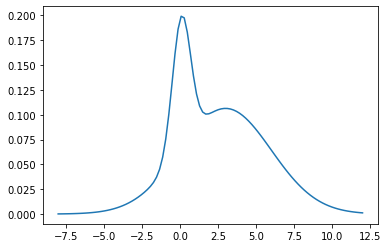

In [419]:
theta_range = torch.linspace(-8, 12, 100)
plt.plot(theta_range, mix.log_prob(theta_range).exp())

In [420]:
mix.mean, mix.stddev

(tensor(2.4200), tensor(2.9356))

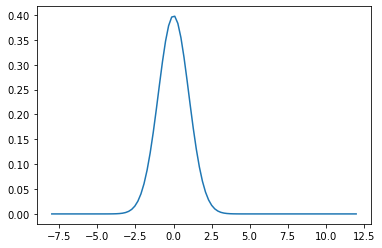

In [421]:
q = dist.Normal(loc = 0., scale=1.)
plt.plot(theta_range, q.log_prob(theta_range).exp())

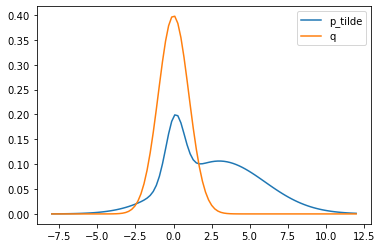

In [422]:
plt.plot(theta_range, mix.log_prob(theta_range).exp(), label='p_tilde')


plt.plot(theta_range, q.log_prob(theta_range).exp(), label='q')
plt.legend()

Choosing proposal q with high variance

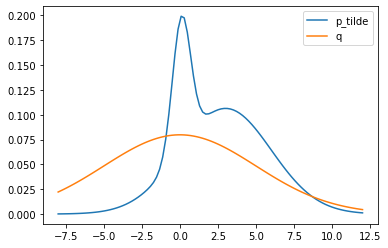

In [396]:
q = dist.Normal(loc = 0., scale=5.)


plt.plot(theta_range, mix.log_prob(theta_range).exp(), label='p_tilde')


plt.plot(theta_range, q.log_prob(theta_range).exp(), label='q')
plt.legend()


Scaling q so that cq(x) >= p(x) for all x

In [437]:
theta_more = theta_range[mix.log_prob(theta_range).exp() >  q.log_prob(theta_range).exp()]
c = (mix.log_prob(theta_more).exp()/q.log_prob(theta_more).exp()).max().item()

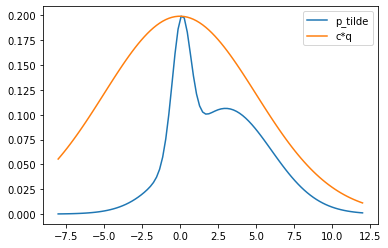

In [438]:
q = dist.Normal(loc = 0., scale=5.)


plt.plot(theta_range, mix.log_prob(theta_range).exp(), label='p_tilde')


plt.plot(theta_range, c*q.log_prob(theta_range).exp(), label='c*q')
plt.legend()


(0.0, 1.0)

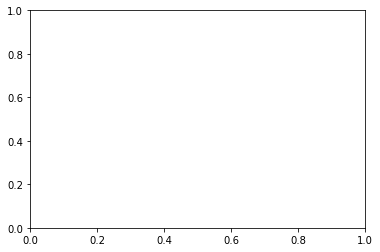

In [447]:
plt.gca().get_xlim()

In [483]:
def plot_rejection(ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    s = q.sample()


    ax.plot(theta_range, mix.log_prob(theta_range).exp(), label='p_tilde')


    ax.plot(theta_range, c*q.log_prob(theta_range).exp(), label='c*q')

    ax.scatter([s], 0, label='s (sample from q)', s=100,color='k')
    cqs = c*q.log_prob(s).exp().item()
    ax.axhline(cqs, label='c*q(s)', color='k')
    ax.plot([s, s], [0, cqs], color='k', linestyle='-.')
    u = dist.Uniform(0, cqs).sample()
    if u > mix.log_prob(s).exp():
        ax.scatter([s], [u], label='u', s=100,color='r')
    else:
        ax.scatter([s], [u], label='u', s=100,color='g')


    ax.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

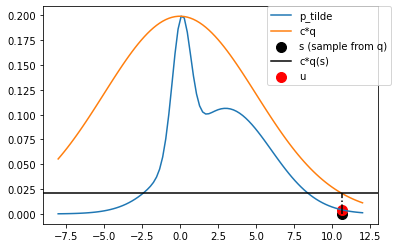

In [484]:
plot_rejection()

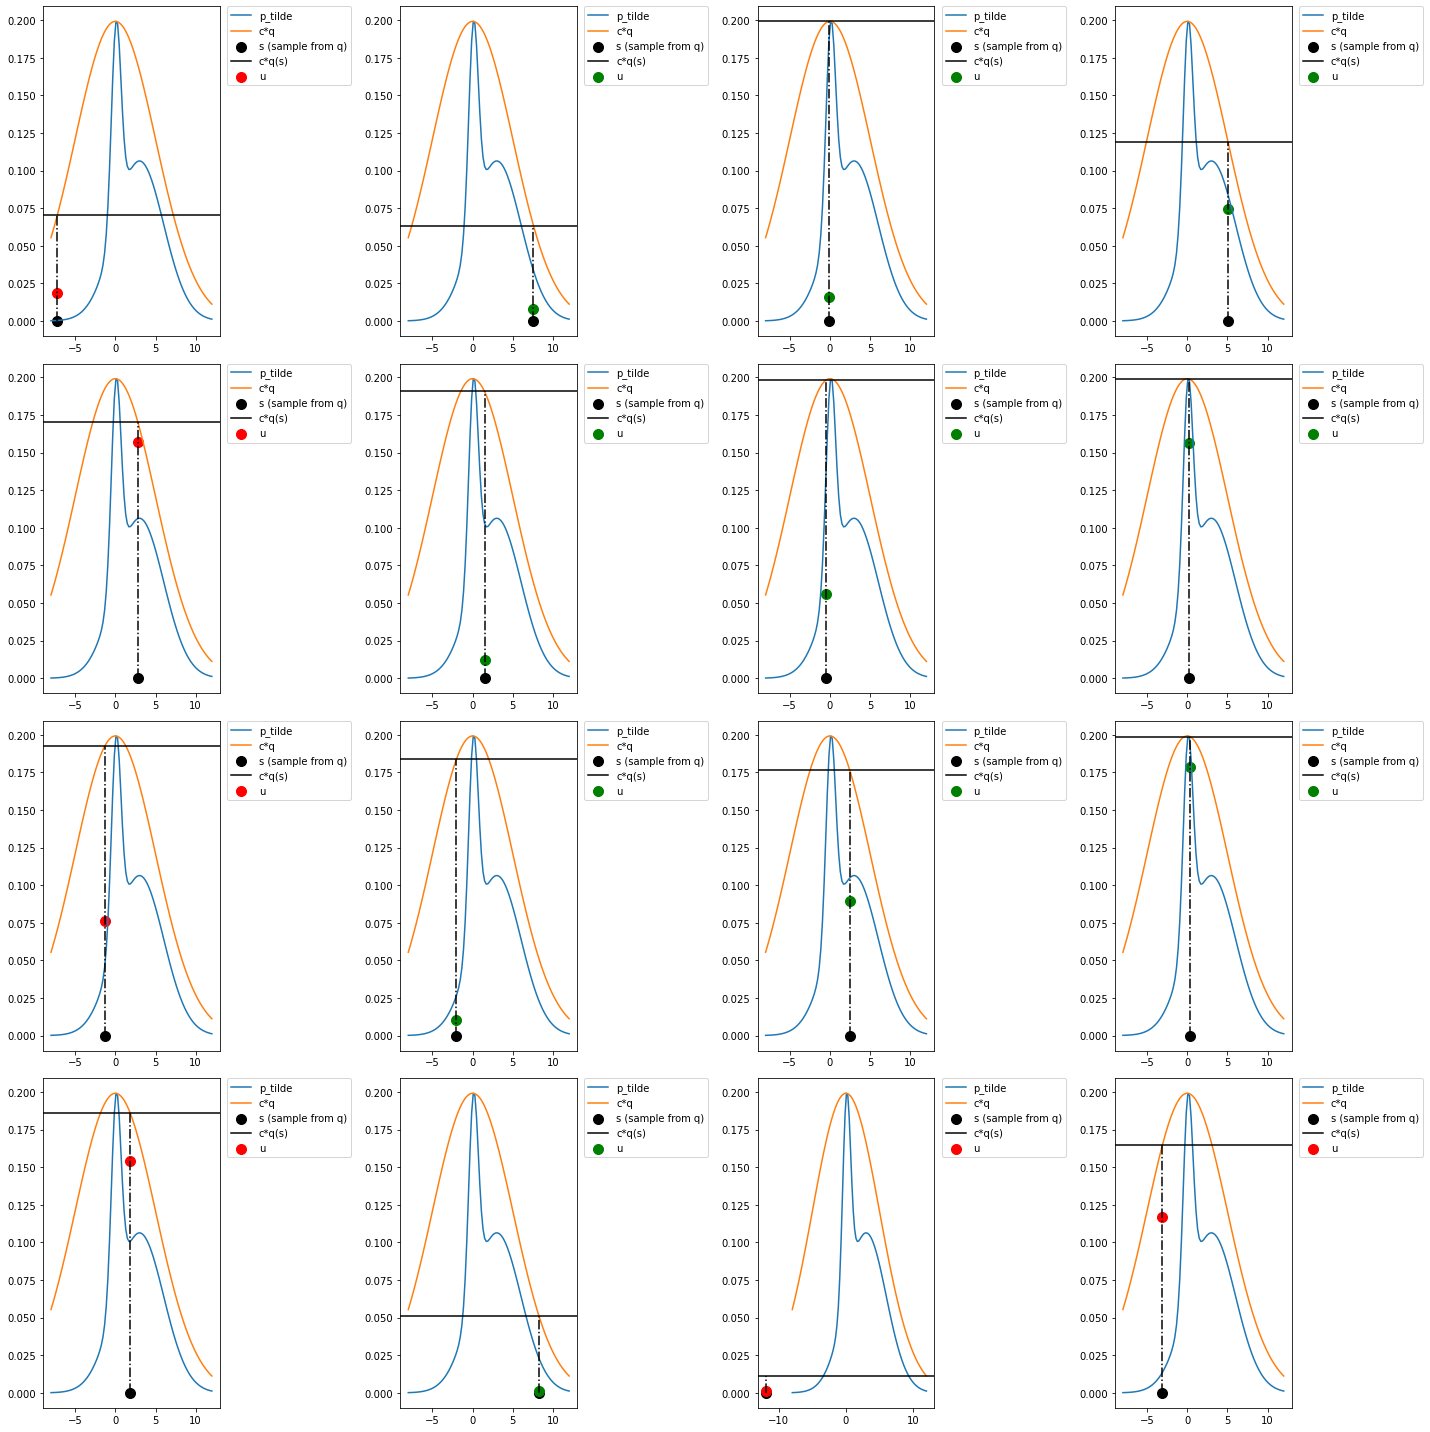

In [485]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
for i in range(16):
    plot_rejection(ax[i//4, i%4])
fig.tight_layout()

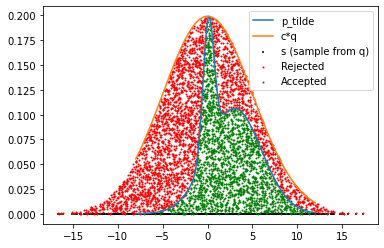

In [521]:
N = 5000
s = q.sample([N])

fig, ax = plt.subplots()
ax.plot(theta_range, mix.log_prob(theta_range).exp(), label='p_tilde')


ax.plot(theta_range, c*q.log_prob(theta_range).exp(), label='c*q')
ax.scatter(s, torch.zeros_like(s), label='s (sample from q)', s=5,color='k', marker='|')
cqs = c*q.log_prob(s).exp()
u = dist.Uniform(0, cqs).sample()
gt_index = u > mix.log_prob(s).exp()
gt = u[gt_index]
s_gt = s[gt_index]

s_lt = s[~gt_index]
lt = u[~gt_index]
ax.scatter(s_gt, gt, s=1,color='r', label='Rejected')
ax.scatter(s_lt, lt, label='Accepted', s=1,color='g')
ax.legend()

<AxesSubplot:ylabel='Density'>

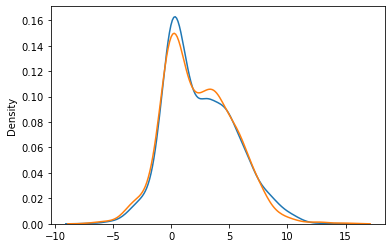

In [528]:
sns.kdeplot(s_lt)
sns.kdeplot(mix.sample([1000]))

### Linear Regression

In [296]:
y = 4*x + torch.randn(5)

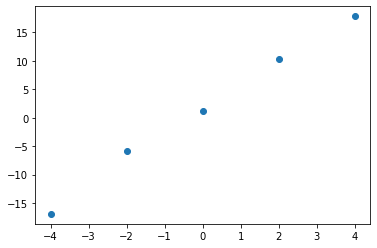

In [297]:
plt.scatter(x, y)

In [298]:
prior = dist.Normal(loc = 0., scale = 1.)

In [299]:
likelihood = lambda t: dist.Normal(loc = x*t, scale=1.).log_prob(y).sum(axis=0).exp().item()

In [300]:
log_likelihood = lambda t: dist.Normal(loc = x*t, scale=1.).log_prob(y).sum(axis=0)

In [301]:
lls = {}
ls = {}
theta_range = torch.linspace(-1, 7, 100)
for t in theta_range:
    lls[t.item()] = log_likelihood(t).item()
    ls[t.item()] = log_likelihood(t).exp().item()

<AxesSubplot:>

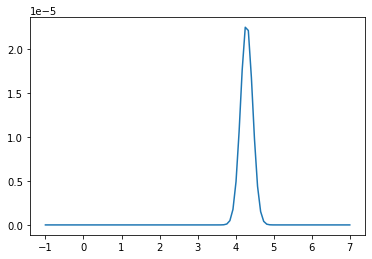

In [302]:
pd.Series(ls).plot()

<AxesSubplot:>

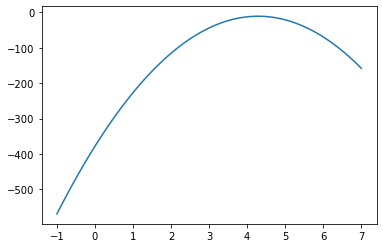

In [303]:
pd.Series(lls).plot()

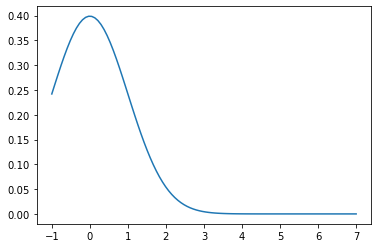

In [304]:
plt.plot(theta_range, prior.log_prob(theta_range).exp())

In [305]:
unnorm_post = lambda t:log_likelihood(t).item() + prior.log_prob(t).item()

In [306]:
up = {}
for t in theta_range:
    up[t.item()] = unnorm_post(t)

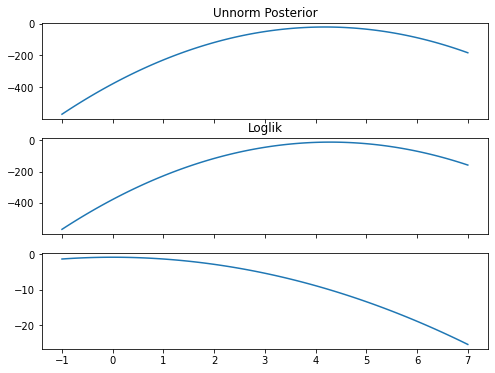

In [307]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize= (8, 6))
pd.Series(up).plot(ax=ax[0], title="Unnorm Posterior")
pd.Series(lls).plot(ax=ax[1], title='Loglik')
ax[2].plot(theta_range, prior.log_prob(theta_range))

In [308]:
torch.exp(torch.tensor(pd.Series(up).values))

tensor([7.6395e-249, 1.9184e-241, 3.6856e-234, 5.4180e-227, 6.0933e-220,
        5.2437e-213, 3.4526e-206, 1.7393e-199, 6.7039e-193, 1.9769e-186,
        4.4607e-180, 7.7007e-174, 1.0172e-167, 1.0280e-161, 7.9493e-156,
        4.7028e-150, 2.1288e-144, 7.3728e-139, 1.9538e-133, 3.9613e-128,
        6.1447e-123, 7.2932e-118, 6.6227e-113, 4.6016e-108, 2.4463e-103,
         9.9501e-99,  3.0965e-94,  7.3730e-90,  1.3432e-85,  1.8722e-81,
         1.9967e-77,  1.6293e-73,  1.0172e-69,  4.8588e-66,  1.7758e-62,
         4.9658e-59,  1.0625e-55,  1.7392e-52,  2.1783e-49,  2.0875e-46,
         1.5306e-43,  8.5864e-41,  3.6854e-38,  1.2103e-35,  3.0411e-33,
         5.8465e-31,  8.5998e-29,  9.6786e-27,  8.3341e-25,  5.4907e-23,
         2.7677e-21,  1.0675e-19,  3.1500e-18,  7.1120e-17,  1.2286e-15,
         1.6238e-14,  1.6421e-13,  1.2706e-12,  7.5216e-12,  3.4069e-11,
         1.1807e-10,  3.1306e-10,  6.3512e-10,  9.8585e-10,  1.1708e-09,
         1.0639e-09,  7.3967e-10,  3.9346e-10,  1.6

In [321]:
q = dist.Normal(loc = 3., scale=.4)
c = 1e-1

In [322]:
q.log_prob(theta_range) + torch.log(torch.tensor(c))

tensor([-52.3052, -50.3054, -48.3465, -46.4283, -44.5509, -42.7144, -40.9186,
        -39.1637, -37.4496, -35.7763, -34.1438, -32.5521, -31.0013, -29.4912,
        -28.0220, -26.5936, -25.2060, -23.8592, -22.5532, -21.2880, -20.0636,
        -18.8801, -17.7373, -16.6354, -15.5743, -14.5540, -13.5745, -12.6358,
        -11.7379, -10.8809, -10.0646,  -9.2892,  -8.5546,  -7.8608,  -7.2078,
         -6.5956,  -6.0242,  -5.4937,  -5.0039,  -4.5550,  -4.1469,  -3.7796,
         -3.4531,  -3.1674,  -2.9225,  -2.7185,  -2.5552,  -2.4328,  -2.3511,
         -2.3103,  -2.3103,  -2.3511,  -2.4328,  -2.5552,  -2.7185,  -2.9225,
         -3.1674,  -3.4531,  -3.7796,  -4.1469,  -4.5550,  -5.0039,  -5.4937,
         -6.0242,  -6.5956,  -7.2078,  -7.8608,  -8.5546,  -9.2892, -10.0646,
        -10.8809, -11.7379, -12.6358, -13.5745, -14.5540, -15.5743, -16.6354,
        -17.7373, -18.8801, -20.0636, -21.2880, -22.5532, -23.8592, -25.2059,
        -26.5936, -28.0220, -29.4912, -31.0013, -32.5521, -34.14

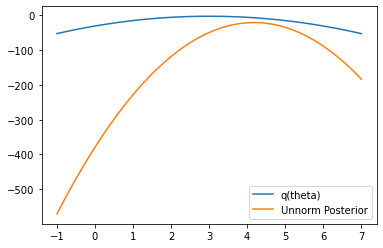

In [324]:
plt.plot(theta_range, q.log_prob(theta_range)+torch.log(torch.tensor(c)), label='q(theta)')
pd.Series(up).plot(ax=plt.gca(), label='Unnorm Posterior')
plt.legend()


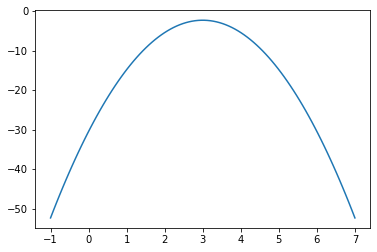

In [325]:
plt.plot(theta_range, q.log_prob(theta_range)+torch.log(torch.tensor(c)), label='q(theta)')

In [326]:
s = q.sample()
s

tensor(3.0192)

In [327]:
q_s = q.log_prob(s).exp()
q_s

tensor(0.9962)

In [328]:
u = dist.Uniform(low=0., high=q_s).sample()

In [329]:
u

tensor(0.8261)

In [330]:
log_q_s = q.log_prob(s).item()

log_p_bar_s = unnorm_post(s)

In [331]:
log_u = torch.log(u).item()

In [332]:
log_q_s, log_p_bar_s, log_u

(-0.0037949681282043457, -48.340909004211426, -0.1910155713558197)

In [333]:
if log_u > log_p_bar_s:
    pass


In [334]:
considered = []
for i in range(10000):
    s = q.sample()
    q_s = q.log_prob(s).exp()

    u = c*dist.Uniform(low=0., high=q_s).sample()
    log_q_s = q.log_prob(s).item()

    log_p_bar_s = unnorm_post(s)
    log_u = torch.log(u).item()
    if log_u > log_p_bar_s:
        pass
    else:
        considered.append(u.item())
        
    

<AxesSubplot:>

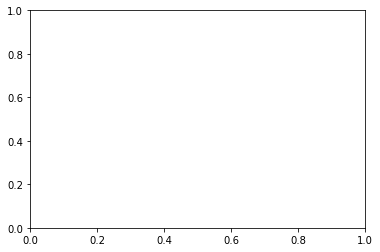

In [335]:
import seaborn as sns
sns.kdeplot(considered)